<a href="https://colab.research.google.com/github/jmestanza/natural-language-processing-practice/blob/main/desafios/Desafio_3/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Desafío 3 de Procesamiento de Lenguaje Natural
## Autor: Mestanza Joaquín
## Numero de SIU: a1726

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Dataset
Originalmente, se había optado por el dataset `THE COMPLETE SHERLOCK HOLMES` que tiene todo el canon de los libros de Arthur Conan Doyle. Pero debido a que es un corpus muy grande  (3868122 de caracteres), la sesión se queda sin ram. Por lo cual se optó por un corpus más chico `The Adventures of Sherlock Holmes` (581565 caracteres).

In [1]:
import os
dataset_path = 'the_adventures_of_sherlock_holmes.txt'
if not os.path.exists(dataset_path):
  # !wget https://raw.githubusercontent.com/jmestanza/natural-language-processing-practice/refs/heads/main/desafios/Desafio_2/cano.txt
  !wget https://raw.githubusercontent.com/jmestanza/natural-language-processing-practice/refs/heads/main/desafios/Desafio_2/the_adventures_of_sherlock_holmes.txt

--2025-04-09 23:51:49--  https://raw.githubusercontent.com/jmestanza/natural-language-processing-practice/refs/heads/main/desafios/Desafio_2/the_adventures_of_sherlock_holmes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607648 (593K) [text/plain]
Saving to: ‘the_adventures_of_sherlock_holmes.txt’

the_adventures_of_s 100%[===================>] 593.41K  --.-KB/s    in 0.02s   

2025-04-09 23:51:49 (30.2 MB/s) - ‘the_adventures_of_sherlock_holmes.txt’ saved [607648/607648]



In [2]:
with open(dataset_path, 'r') as f:
  text = f.read()

print(len(text))
print(text[:1000])

581565
﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doyle

Release date: March 1, 1999 [eBook #1661]
                Most recently updated: October 10, 2023

Language: English

Credits: an anonymous Project Gutenberg volunteer and Jose Menendez


*** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***




The Adventures of Sherlock Holmes

by Arthur Conan Doyle


Contents

   I.     A Scandal in Bohemia
   II.    The Red-Headed League
   II

## Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus de texto puede ser considerado un documento en sí mismo y el tamaño de contexto puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [3]:
# seleccionamos el tamaño de contexto
max_context_size = 100

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(text)

# la longitud de vocabulario de caracteres es:
print(len(chars_vocab))

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}


98


## Tokenizar

In [4]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in text]
tokenized_text[:25]

[15,
 77,
 97,
 19,
 84,
 72,
 85,
 76,
 51,
 19,
 13,
 74,
 84,
 14,
 58,
 74,
 19,
 56,
 57,
 19,
 85,
 0,
 84,
 19,
 79]

## Organizando y estructurando el dataset

In [5]:
import numpy as np
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [6]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [7]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [8]:
X_train = np.array(tokenized_sentences_train[:-1])
y_train = np.array(tokenized_sentences_train[1:])

In [9]:
print(len(tokenized_sentences_val))
print(len(tokenized_sentences_val[0]))

582
0


Nótese que estamos estructurando el problema de aprendizaje como many-to-many:

Entrada: secuencia de tokens $[x_0,x_1, ..., x_n]$

Target: secuencia de tokens $[x_1,x_2, ...,x_{n+1}]$

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como many-to-one en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable tokenized_sentences los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [10]:
X_train.shape

(523265, 100)

In [11]:
X_train[0,:10]

array([15, 77, 97, 19, 84, 72, 85, 76, 51, 19])

In [12]:
y_train[0,:10]

array([77, 97, 19, 84, 72, 85, 76, 51, 19, 13])

In [13]:
vocab_size = len(chars_vocab)
vocab_size

98

## Definiendo el modelo

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas CategoryEncoding que transforma a índices a vectores OHE y TimeDistributed que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [14]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential
model = Sequential([
    Input(shape=(None, 1)),
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 98)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          59,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 98)            │          19,698 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,498 (310.54 KB)

 Trainable params: 79,498 (310.54 KB)

 Non-trainable params: 0 (0.00 B)

## Perplexity callback

Se tuvo que cambiar el enfoque de la implementación del cálculo de perplexity a un enfoque de tipo `batch` ya que la sesión de Colab se terminaba por quedarse sin memoria.

In [15]:
from tensorflow import keras
class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data, history_ppl, patience=5, batch_size=512, eval_every=1, model_name=None):
        self.model_name = model_name,
        self.batch_size = batch_size
        self.patience = patience
        self.eval_every = eval_every
        self.history_ppl = history_ppl
        self.times = []

        self.min_score = np.inf
        self.patience_counter = 0

        self.sequences = []
        self.targets = []
        self.splits = []
        idx = 0

        for seq in val_data:
            if len(seq) <= 1:
                continue
            subseq = [seq[:i] for i in range(1, len(seq))]
            target = [seq[i] for i in range(1, len(seq))]

            self.sequences.extend(subseq)
            self.targets.extend(target)
            self.splits.append((idx, idx + len(subseq)))
            idx += len(subseq)

        self.targets = np.array(self.targets)

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.times.append(elapsed)
        print(f"\nEpoch {epoch + 1} took {elapsed:.2f} seconds")

        # Only evaluate every N epochs
        if (epoch + 1) % self.eval_every != 0:
            print("Skipping perplexity evaluation this epoch.")
            self.history_ppl.append(None)  # placeholder
            return

        start_time = time.time()
        print("\nEvaluating perplexity on validation set...")
        preds_all = []

        for i in range(0, len(self.sequences), self.batch_size):
            batch_seqs = self.sequences[i:i+self.batch_size]
            padded = pad_sequences(batch_seqs, maxlen=max_context_size, padding='pre')
            preds = self.model.predict(padded, verbose=0)[:, -1, :]  # last step only
            preds_all.append(preds)

        predictions = np.vstack(preds_all)
        chosen_probs = predictions[np.arange(len(predictions)), self.targets]
        log_probs = np.log(chosen_probs + 1e-10)

        scores = []
        for start, end in self.splits:
            mean_log_prob = np.mean(log_probs[start:end])
            scores.append(np.exp(-mean_log_prob))

        current_score = np.mean(scores)
        self.history_ppl.append(current_score)

        elapsed = time.time() - start_time
        print(f'\nMean Perplexity: {current_score:.4f} | Evaluation Time: {elapsed:.2f} seconds\n')

        if current_score < self.min_score:
            self.min_score = current_score
            if self.model_name is not None:
              self.model.save(f"{self.model_name}_best_model.keras")
            else:
              self.model.save("best_model.keras")
            print("Saved new best model.")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print("Early stopping triggered.")
                self.model.stop_training = True


## Entrenamiento

```python
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
# batch_size = 512 -> 61 segs perplex calc time
# batch_size = 1024 -> 50 segs perplex calc time
# batch_size = 2048 -> 43 segs perplex calc time <-- nos quedamos con este porque usa menos memoria y el beneficio en tiempo es aprox la misma que 4096
# batch_size = 4096 -> 41.44 segs perplex calc time
ppl_cb = PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, batch_size=2048)
model.fit(X_train, y_train, epochs=20, callbacks=[ppl_cb], batch_size=1024)

```



```
Epoch 1/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.2485
Evaluating perplexity on validation set...

Mean Perplexity: 10.9563 | Evaluation Time: 36.94 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - loss: 2.2484
Epoch 2/20
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.0832
Evaluating perplexity on validation set...

Mean Perplexity: 9.7245 | Evaluation Time: 35.89 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - loss: 2.0830
Epoch 3/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.9803
Evaluating perplexity on validation set...

Mean Perplexity: 9.1274 | Evaluation Time: 35.50 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 55s 107ms/step - loss: 1.9803
Epoch 4/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.9175
Evaluating perplexity on validation set...

Mean Perplexity: 8.9740 | Evaluation Time: 37.15 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - loss: 1.9174
Epoch 5/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.8755
Evaluating perplexity on validation set...

Mean Perplexity: 8.7260 | Evaluation Time: 36.53 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - loss: 1.8754
Epoch 6/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8465
Evaluating perplexity on validation set...

Mean Perplexity: 8.4781 | Evaluation Time: 37.64 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - loss: 1.8465
Epoch 7/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.8236
Evaluating perplexity on validation set...

Mean Perplexity: 8.4720 | Evaluation Time: 35.53 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - loss: 1.8236
Epoch 8/20
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.8069
Evaluating perplexity on validation set...

Mean Perplexity: 8.5718 | Evaluation Time: 36.44 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - loss: 1.8069
Epoch 9/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7931
Evaluating perplexity on validation set...

Mean Perplexity: 8.1454 | Evaluation Time: 35.76 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 55s 108ms/step - loss: 1.7931
Epoch 10/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7810
Evaluating perplexity on validation set...

Mean Perplexity: 8.2308 | Evaluation Time: 39.07 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - loss: 1.7810
Epoch 11/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7707
Evaluating perplexity on validation set...

Mean Perplexity: 8.3993 | Evaluation Time: 36.41 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 79s 110ms/step - loss: 1.7707
Epoch 12/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7633
Evaluating perplexity on validation set...

Mean Perplexity: 7.4498 | Evaluation Time: 38.13 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - loss: 1.7633
Epoch 13/20
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7554
Evaluating perplexity on validation set...

Mean Perplexity: 8.3274 | Evaluation Time: 36.81 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - loss: 1.7554
Epoch 14/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7504
Evaluating perplexity on validation set...

Mean Perplexity: 8.4714 | Evaluation Time: 38.36 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 113ms/step - loss: 1.7504
Epoch 15/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7443
Evaluating perplexity on validation set...

Mean Perplexity: 8.5419 | Evaluation Time: 37.85 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - loss: 1.7443
Epoch 16/20
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7386
Evaluating perplexity on validation set...

Mean Perplexity: 7.9335 | Evaluation Time: 38.13 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - loss: 1.7386
Epoch 17/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.7351
Evaluating perplexity on validation set...

Mean Perplexity: 7.7394 | Evaluation Time: 35.64 seconds

Early stopping triggered.
512/512 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - loss: 1.7351
<keras.src.callbacks.history.History at 0x7c1d405cded0>
```





```python
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

```



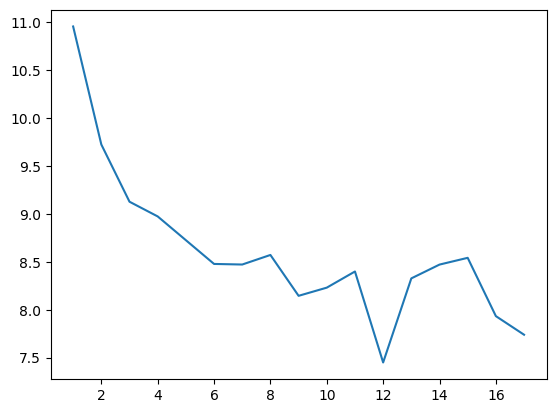

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

## Predicción del próximo caracter

In [ ]:
# !pip install -q gradio
# import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

# iface = gr.Interface(
#     fn=model_response,
#     inputs=["textbox"],
#     outputs="text")

# iface.launch(debug=True)

In [ ]:
model_response('Sherloc')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'Sherlock'

In [ ]:
model_response('Holme')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


'Holmes'

In [ ]:
model_response('Dr. Watso')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'Dr. Watson'

In [ ]:
seq = "Sherlo"
for i in range(10):
  seq = model_response(seq)
  print(seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Sherloc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Sherlock
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Sherlock 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Sherlock H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sherlock Ha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sherlock Had
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sherlock Had 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sherlock Had b
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sherlock Had be
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sherlock Had bee


In [ ]:
seq = "Dr. Wats"
for i in range(10):
  seq = model_response(seq)
  print(seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Dr. Watso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Dr. Watson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Dr. Watson,
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Dr. Watson, 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Dr. Watson, a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Dr. Watson, an
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Dr. Watson, and
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Dr. Watson, and 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Dr. Watson, and a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Dr. Watson, and a 


## Generación de secuencias

In [ ]:

def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text


In [ ]:
input_text='Sherlock'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Sherlock Had been and a looked and a l'

In [ ]:
input_text='Dr. Wats'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Dr. Watson, and a looked and a looked '

## Beam search y muestreo aleatorio

In [37]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [38]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="Sherlock Holmes")

In [ ]:
salidas[0]


array([60, 25, 10, 80, 47, 79, 72, 81, 84, 18, 79, 47, 26, 10, 96, 24, 84,
       56, 66, 34, 84, 40, 84, 96, 25, 79, 68, 47, 34, 84, 66, 79, 12, 84,
       56])

In [ ]:
# veamos las salidas
decode(salidas[0])

'Sherlock Holmes, and I should not a'

## Analizamos el caso de utilizar una LSTM o GRU

Nótese que seteamos `recurrent_dropout=0.0` para estos nuevos casos,
esto es porque hacerlo nos permite utilizar CuDNN (CUDA® Deep Neural Network library), lo cual reduce drásticamente los tiempos de entrenamiento para esos modelos. Realizando pruebas pasó el tiempo por epoch de 140 segundos a 20 segundos en el caso de LSTM, es decir 7 veces menos tardó en total. En general se dice que puede acelerar los entrenamientos entre un 5x y un 10x.

Viene a coste de que vamos a tener que utilizar otro tipo de regularización ya que no se tiene acceso para hacer fine tuning en el backend de CuDNN.

Podemos acelerar aún más el tiempo de entrenamiento utilizando
```
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
```
Que si bien redujo el tiempo por epoch para LSTM, lo redujo de 20 a 15 segundos a cambio de una pérdida en la precisión.

En este caso se prefiere mantener la configuración por defecto teniendo más precisión sobre los cálculos.

In [ ]:
from keras.layers import SimpleRNN, LSTM, GRU, Input, TimeDistributed, CategoryEncoding, Dense
from keras.models import Model, Sequential


# para la comparación hacemos que tengan aproximadamente la misma cantidad de parámetros
cfg_model = {
    "SimpleRNN": {"units": 200, "recurrent_dropout": 0.1},
    "LSTM": {"units": 92, "recurrent_dropout": 0.0},
    "GRU": {"units": 109, "recurrent_dropout": 0.0}
}


all_models = {}
for model in [SimpleRNN,LSTM, GRU]:
    complete_model = Sequential([
        Input(shape=(None, 1)),
        TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
        model(**cfg_model[model.__name__], return_sequences=True, dropout=0.1),
        Dense(vocab_size, activation="softmax")
    ])
    complete_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    all_models[model.__name__] = complete_model
    print(complete_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 98)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 200)           │          59,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 98)            │          19,698 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,498 (310.54 KB)

 Trainable params: 79,498 (310.54 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, None, 98)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 92)            │          70,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 98)            │           9,114 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,402 (310.16 KB)

 Trainable params: 79,402 (310.16 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, None, 98)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 109)           │          68,343 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 98)            │          10,780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,123 (309.07 KB)

 Trainable params: 79,123 (309.07 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import time
all_perplexities = {}
for name, curr_model in all_models.items():
    print(f"Using model with {name}")
    history_ppl = []
    # should test with more patience
    ppl_cb = PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, batch_size=2048, eval_every=1, model_name=name, patience=10)
    curr_model.fit(X_train, y_train, epochs=20, callbacks=[ppl_cb], batch_size=1024)
    all_perplexities[model.__name__] = history_ppl

Using model with SimpleRNN
Epoch 1/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8317
Epoch 1 took 30.84 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 12.3332 | Evaluation Time: 49.57 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - loss: 2.8311
Epoch 2/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.2039
Epoch 2 took 26.32 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 10.2213 | Evaluation Time: 40.92 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 67s 118ms/step - loss: 2.2037
Epoch 3/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.0542
Epoch 3 took 41.47 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 8.9955 | Evaluation Time: 41.78 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 121ms/step - loss: 2.0541
Epoch 4/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.9622
Epoch 4 took 40.46 seconds

Evaluating perplexity on validation se

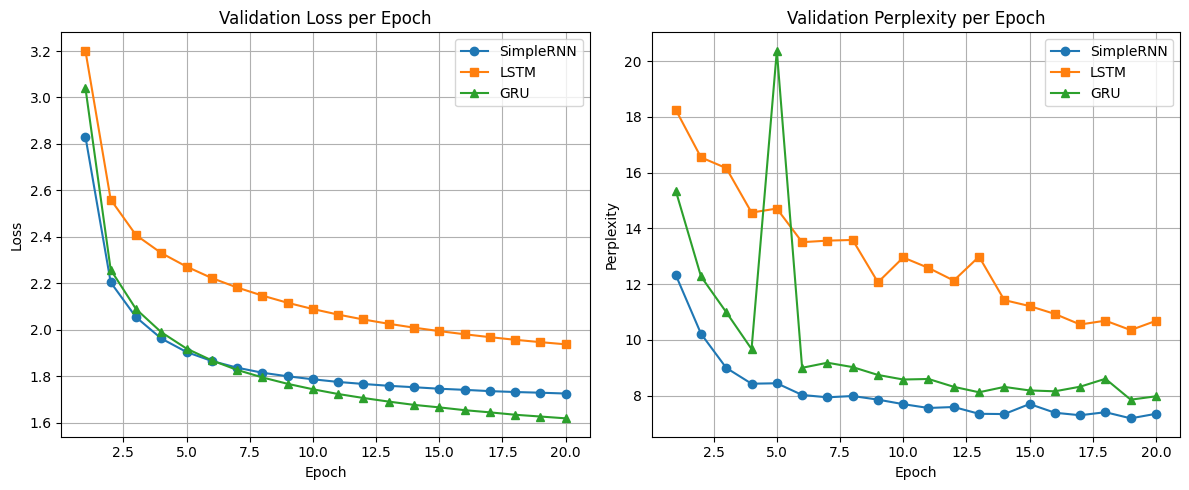

In [ ]:
simple_rnn_losses = [
    2.8317, 2.2039, 2.0542, 1.9622, 1.9040,
    1.8654, 1.8366, 1.8148, 1.7994, 1.7866,
    1.7751, 1.7664, 1.7585, 1.7524, 1.7459,
    1.7411, 1.7356, 1.7317, 1.7288, 1.7252
]

simple_rnn_perplexities = [
    12.3332, 10.2213, 8.9955, 8.4291, 8.4450,
    8.0256, 7.9412, 7.9881, 7.8578, 7.6961,
    7.5585, 7.5939, 7.3496, 7.3406, 7.7010,
    7.3878, 7.2982, 7.4073, 7.1870, 7.3502
]

lstm_loss_per_epoch = [
    3.2013, 2.5604, 2.4075, 2.3302, 2.2718,
    2.2224, 2.1818, 2.1469, 2.1159, 2.0890,
    2.0651, 2.0440, 2.0255, 2.0089, 1.9940,
    1.9805, 1.9680, 1.9566, 1.9465, 1.9371
]

lstm_mean_perplexity_per_epoch = [
    18.2579, 16.5467, 16.1626, 14.5687, 14.7113,
    13.5063, 13.5609, 13.5858, 12.0659, 12.9570,
    12.5823, 12.1287, 12.9876, 11.4278, 11.2152,
    10.9315, 10.5534, 10.6904, 10.3534, 10.6847
]

gru_losses = [
    3.0416, 2.2581, 2.0891, 1.9894, 1.9188,
    1.8679, 1.8269, 1.7946, 1.7670, 1.7436,
    1.7231, 1.7060, 1.6905, 1.6764, 1.6656,
    1.6536, 1.6442, 1.6339, 1.6262, 1.6184
]

gru_mean_perplexities = [
    15.3566, 12.2761, 10.9936, 9.6725, 20.3736,
    8.9996, 9.1822, 9.0247, 8.7435, 8.5799,
    8.5985, 8.3177, 8.1219, 8.3144, 8.1878,
    8.1568, 8.3224, 8.6058, 7.8561, 7.9778
]

import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# --- Plotting Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, simple_rnn_losses, label="SimpleRNN", marker='o')
plt.plot(epochs, lstm_loss_per_epoch, label="LSTM", marker='s')
plt.plot(epochs, gru_losses, label="GRU", marker='^')
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Plotting Perplexity ---
plt.subplot(1, 2, 2)
plt.plot(epochs, simple_rnn_perplexities, label="SimpleRNN", marker='o')
plt.plot(epochs, lstm_mean_perplexity_per_epoch, label="LSTM", marker='s')
plt.plot(epochs, gru_mean_perplexities, label="GRU", marker='^')
plt.title("Validation Perplexity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Comparación de modelos utilizando Embeddings

In [16]:
from keras.layers import SimpleRNN, LSTM, GRU, Input, TimeDistributed, Dense, Embedding
from keras.models import Sequential

cfg_model = {
    "SimpleRNN": {"units": 200, "recurrent_dropout": 0.1},
    "LSTM": {"units": 92, "recurrent_dropout": 0.0},
    "GRU": {"units": 109, "recurrent_dropout": 0.0}
}

embedding_dim = 32  # ajustable
all_models = {}

for model in [SimpleRNN, LSTM, GRU]:
    complete_model = Sequential([
        Input(shape=(None,)),  # secuencia de índices
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        model(**cfg_model[model.__name__], return_sequences=True, dropout=0.1),
        TimeDistributed(Dense(vocab_size, activation="softmax"))
    ])
    complete_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    all_models[model.__name__] = complete_model
    print(f"\nModel: {model.__name__}")
    complete_model.summary()


Model: SimpleRNN


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 32)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 200)           │          46,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 98)            │          19,698 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,434 (271.23 KB)

 Trainable params: 69,434 (271.23 KB)

 Non-trainable params: 0 (0.00 B)


Model: LSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 32)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 92)            │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 98)            │           9,114 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,250 (227.54 KB)

 Trainable params: 58,250 (227.54 KB)

 Non-trainable params: 0 (0.00 B)


Model: GRU


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 32)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 109)           │          46,761 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 98)            │          10,780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,677 (237.02 KB)

 Trainable params: 60,677 (237.02 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import time
all_perplexities = {}
for name, curr_model in all_models.items():
    print(f"Using model with {name}")
    history_ppl = []
    ppl_cb = PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, batch_size=2048, eval_every=1, model_name=name)
    curr_model.fit(X_train, y_train, epochs=20, callbacks=[ppl_cb], batch_size=1024)
    all_perplexities[name] = history_ppl

Using model with SimpleRNN
Epoch 1/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.6552
Epoch 1 took 90.62 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 10.8848 | Evaluation Time: 62.97 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 154s 258ms/step - loss: 2.6545
Epoch 2/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.9260
Epoch 2 took 105.34 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 9.0774 | Evaluation Time: 44.45 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 150s 189ms/step - loss: 1.9258
Epoch 3/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.7854
Epoch 3 took 52.77 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 8.2017 | Evaluation Time: 42.97 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 96s 187ms/step - loss: 1.7853
Epoch 4/20
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.7209
Epoch 4 took 98.59 seconds

Evaluating perplexity on validat

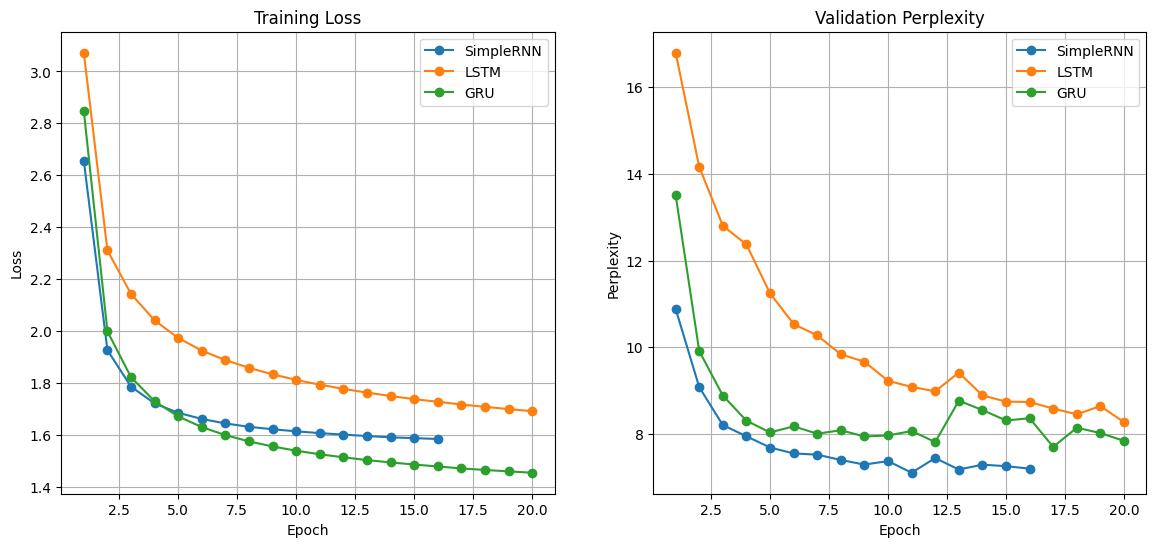

In [21]:
import matplotlib.pyplot as plt

# Example loss and perplexity values from your logs
epochs = list(range(1, 21))

# Replace these lists with your actual logged values from each model
simple_rnn_loss = [
    2.6552,
    1.9260,
    1.7854,
    1.7209,
    1.6846,
    1.6610,
    1.6436,
    1.6307,
    1.6212,
    1.6132,
    1.6063,
    1.6006,
    1.5950,
    1.5901,
    1.5870,
    1.5837
]

simple_rnn_perplexity = [
    10.8848,
    9.0774,
    8.2017,
    7.9429,
    7.6841,
    7.5478,
    7.5194,
    7.3967,
    7.2903,
    7.3710,
    7.1025,
    7.4413,
    7.1761,
    7.2882,
    7.2539,
    7.1965
]

lstm_loss = [
    3.0723, 2.3107, 2.1426, 2.0408, 1.9732,
    1.9242, 1.8876, 1.8580, 1.8327, 1.8114,
    1.7930, 1.7769, 1.7624, 1.7494, 1.7373,
    1.7271, 1.7165, 1.7076, 1.6989, 1.6909
]


lstm_perplexity = [
    16.7954, 14.1607, 12.8023, 12.3699, 11.2426,
    10.5327, 10.2723, 9.8350, 9.6646, 9.2239,
    9.0827, 8.9813, 9.4131, 8.8881, 8.7441,
    8.7348, 8.5822, 8.4514, 8.6406, 8.2687
]


gru_loss = [
    2.8474, 1.9986, 1.8218, 1.7290, 1.6706,
    1.6296, 1.5985, 1.5745, 1.5548, 1.5386,
    1.5247, 1.5132, 1.5022, 1.4935, 1.4852,
    1.4778, 1.4704, 1.4643, 1.4589, 1.4537
]

gru_perplexity = [
    13.5103, 9.9111, 8.8838, 8.3028, 8.0326,
    8.1730, 8.0034, 8.0823, 7.9389, 7.9627,
    8.0652, 7.8101, 8.7642, 8.5504, 8.3078,
    8.3604, 7.6983, 8.1404, 8.0183, 7.8365
]


# --- Plotting Loss ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs[:len(simple_rnn_loss)], simple_rnn_loss, label='SimpleRNN', marker='o')
plt.plot(epochs, lstm_loss, label='LSTM', marker='o')
plt.plot(epochs, gru_loss, label='GRU', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)


# --- Plotting Perplexity ---
plt.subplot(1, 2, 2)

# Filter out None values for SimpleRNN
simple_rnn_epochs = [e for e, p in zip(epochs, simple_rnn_perplexity) if p is not None]
simple_rnn_perp = [p for p in simple_rnn_perplexity if p is not None]
plt.plot(simple_rnn_epochs, simple_rnn_perp, label='SimpleRNN', marker='o')

# Filter out None values for LSTM
lstm_epochs = [e for e, p in zip(epochs, lstm_perplexity) if p is not None]
lstm_perp = [p for p in lstm_perplexity if p is not None]
plt.plot(lstm_epochs, lstm_perp, label='LSTM', marker='o')

# Filter out None values for GRU
gru_epochs = [e for e, p in zip(epochs, gru_perplexity) if p is not None]
gru_perp = [p for p in gru_perplexity if p is not None]
plt.plot(gru_epochs, gru_perp, label='GRU', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.legend()
plt.grid(True)

El modelo que mejor perplexity da dentro de 20 epochs es el de SimpleRNN, sin embargo podemos notar una tendencia de las otras dos arquitecturas a ir descendiendo consistentemente las métricas, mientras que SimpleRNN terminó antes el entrenamiento por early stopping. Esto nos da un indicio de que si hubieramos seguido entrenando, probablemente las métricas para los modelos de LSTM o GRU podrían dar mejor.

## Generación de secuencias con GRU + Embeddings

In [23]:
trained_models = [el for el in os.listdir() if el.endswith('keras')]
trained_models

["('SimpleRNN',)_best_model.keras",
 "('LSTM',)_best_model.keras",
 "('GRU',)_best_model.keras"]

In [25]:
from keras.layers import SimpleRNN, LSTM, GRU, Input, TimeDistributed, CategoryEncoding, Dense
from keras.models import Model, Sequential, load_model

from keras.layers import Embedding
import time

delta_perplexities = {}
for filename in trained_models:
    print(f"Using model with {filename}")
    loaded_model = load_model(filename)
    history_ppl = []
    ppl_cb = PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, batch_size=2048, eval_every=1, model_name=filename)
    loaded_model.fit(X_train, y_train, epochs=10, callbacks=[ppl_cb], batch_size=1024)
    delta_perplexities[filename] = history_ppl

Using model with ('SimpleRNN',)_best_model.keras
Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.6005
Epoch 1 took 94.87 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 7.2443 | Evaluation Time: 63.10 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 158s 267ms/step - loss: 1.6005
Epoch 2/10
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.5954
Epoch 2 took 100.41 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 7.2504 | Evaluation Time: 43.57 seconds

512/512 ━━━━━━━━━━━━━━━━━━━━ 144s 190ms/step - loss: 1.5954
Epoch 3/10
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.5911
Epoch 3 took 98.55 seconds

Evaluating perplexity on validation set...

Mean Perplexity: 7.2361 | Evaluation Time: 43.01 seconds

Saved new best model.
512/512 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - loss: 1.5911
Epoch 4/10
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.5870
Epoch 4 took 99.31 seconds

Evaluating perplexity on validat

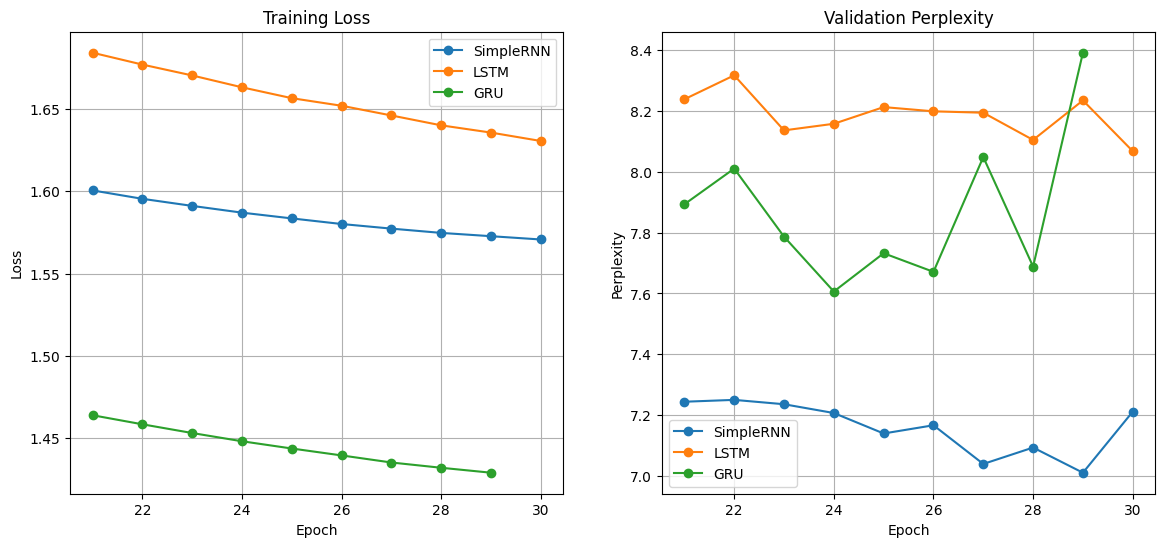

In [31]:
simple_rnn_loss = [
    1.6005, 1.5954, 1.5911, 1.5870, 1.5835,
    1.5801, 1.5773, 1.5747, 1.5727, 1.5707
]

simple_rnn_perplexity = [
    7.2443, 7.2504, 7.2361, 7.2072, 7.1400,
    7.1670, 7.0399, 7.0938, 7.0111, 7.2117
]

lstm_loss = [
    1.6841, 1.6769, 1.6703, 1.6631, 1.6565,
    1.6519, 1.6460, 1.6400, 1.6356, 1.6305
]

lstm_perplexity = [
    8.2379, 8.3166, 8.1357, 8.1574, 8.2122,
    8.1983, 8.1937, 8.1043, 8.2342, 8.0674
]

gru_loss = [
    1.4640, 1.4585, 1.4532, 1.4482, 1.4438,
    1.4396, 1.4353, 1.4321, 1.4291
]

gru_perplexity = [
    7.8929, 8.0102, 7.7866, 7.6063, 7.7321,
    7.6710, 8.0480, 7.6882, 8.3908  # Early stopping after this
]


# --- Plotting Loss ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot([el+20 for el in epochs[:len(simple_rnn_loss)]], simple_rnn_loss, label='SimpleRNN', marker='o')
plt.plot([el+20 for el in epochs[:len(lstm_loss)]], lstm_loss, label='LSTM', marker='o')
plt.plot([el+20 for el in  epochs[:len(gru_loss)]], gru_loss, label='GRU', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)


# --- Plotting Perplexity ---
plt.subplot(1, 2, 2)

# Filter out None values for SimpleRNN
simple_rnn_epochs = [e+20 for e, p in zip(epochs, simple_rnn_perplexity) if p is not None]
simple_rnn_perp = [p for p in simple_rnn_perplexity if p is not None]
plt.plot(simple_rnn_epochs, simple_rnn_perp, label='SimpleRNN', marker='o')

# Filter out None values for LSTM
lstm_epochs = [e+20 for e, p in zip(epochs, lstm_perplexity) if p is not None]
lstm_perp = [p for p in lstm_perplexity if p is not None]
plt.plot(lstm_epochs, lstm_perp, label='LSTM', marker='o')

# Filter out None values for GRU
gru_epochs = [e+20 for e, p in zip(epochs, gru_perplexity) if p is not None]
gru_perp = [p for p in gru_perplexity if p is not None]
plt.plot(gru_epochs, gru_perp, label='GRU', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity')
plt.legend()
plt.grid(True)


Frente a estas curvas uno podría pensar que la convergencia de LSTM es relativamente lenta, con lo cual se podría aplicar un fine tuning de hiperparámetros para poder llegar a una convergencia más rápida. Por una cuestión del tiempo de entrenamiento, esto se propone para futuras investigaciones.

Probaremos a continuación con los 3 modelos y sus predicciones.

In [35]:
best_models =[el for el in os.listdir() if '_best_model.keras",)_best_model.keras' in el]

temp = 1.0 — Standard softmax.

temp < 1.0 (e.g., 0.7, 0.5) — Makes the distribution sharper, increasing the confidence (peaky distribution, less randomness).

temp > 1.0 (e.g., 1.5, 2.0) — Makes the distribution flatter, increasing randomness in selection.

temp → 0 — Approaches argmax (greedy)
temp → ∞ — Approaches uniform sampling (all items nearly equally likely).

In [43]:
def decode(seq):
    flat_seq = np.array(seq).flatten()
    return ''.join([idx2char[int(ch)] for ch in flat_seq if int(ch) in idx2char])

In [ ]:
input_text_list = ['Sherlock Holmes', 'Watson', 'Sherlock', 'Dr.']

for model_saved in best_models:
  loaded_model = load_model(model_saved)
  for input_text in input_text_list:
    for mode in ['det', 'sto']:
      if mode == 'sto':
        for temp in [0.2, 1, 2, 4]:
          print('iterating: ', model_saved, input_text, mode, temp)
          salidas = beam_search(loaded_model,num_beams=10,num_words=30,temp=temp,input=input_text, mode='sto')
          print(decode(salidas[0]))
      else:
        print('iterating: ', model_saved, input_text, mode)
        salidas = beam_search(loaded_model,num_beams=10,num_words=30,input=input_text, mode='det')
        print(decode(salidas[0]))

iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Sherlock Holmes det
Sherlock Holmes, and there was that there is 
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Sherlock Holmes sto 0.2
Sherlock Holmes, and the matter of the live t
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Sherlock Holmes sto 1
Sherlock Holmes that there is that the proses
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Sherlock Holmes sto 2
Sherlock Holmes. It is tell him the dedered y
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Sherlock Holmes sto 4
Sherlock Holmes reanseling
broel! Ar fapsaph:
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Watson det
Watson, and that there that there is
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Watson sto 0.2
Watson of the man and the might that
iterating:  ("('LSTM',)_best_model.keras",)_best_model.keras Watson sto 1
Watson which have there was and than
iterating:  ("('LSTM',